In [2]:
import os
from glob import glob 

import pandas as pd
import numpy as np
import sqlite3

In [3]:
import lsst.afw.geom as afwGeom
import lsst.afw.cameraGeom
import lsst.geom as geom

from lsst.afw.geom import makeSkyWcs
from lsst.obs.lsst.imsim import ImsimMapper
from lsst.daf.persistence import Butler

from collections import OrderedDict as Odict
from astropy import time

In [4]:
from importlib import reload, import_module

In [5]:
import sys
sys.path.insert(0, '..')

In [6]:
import dm_utilities as dmu
reload(dmu)

<module 'dm_utilities' from '../dm_utilities.py'>

In [7]:
from matplotlib.path import Path
import matplotlib.patches as patches

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# creating the telescope camera objects
mapper = ImsimMapper()
camera = mapper.camera
trans = [detector.getTransform(lsst.afw.cameraGeom.cameraSys.PIXELS,
         lsst.afw.cameraGeom.cameraSys.FIELD_ANGLE) for detector in camera]
boxes = [detector.getBBox() for detector in camera]
names = [detector.getName() for detector in camera]
visitab = pd.read_csv('../catalogs+tables/full_t_visits_from_minion.csv')

In [10]:
## start from images up to the DM catalogs from butler/Sn table
deep_diff_path = '/global/cscratch1/sd/bos0109/templates_rect/rerun/diff_rect/deepDiff'

calexprepo = '/global/cscratch1/sd/desc/DC2/data/Run2.1i/rerun/calexp-v1' 
b = Butler(calexprepo)

In [19]:
visit_paths = glob(deep_diff_path+'/*')
visit_paths.reverse()
for avisit in visit_paths:
    dirname = os.path.basename(avisit)
    n_visit, filt = dirname.strip('v').split('-')
    n_visit = int(n_visit)
    filt = filt[-1]
    if filt in ('u', 'y') or n_visit not in list(visitab.obsHistID):
        print('continue')
        continue
    
    raft_list = glob(avisit+'/R*')
    for araft in raft_list:
        raft_n = int(os.path.basename(araft)[1:])
        #print(raft_n)
        # have visit number and raft number
        detlist = glob(araft+'/diaSrc_*.fits')
        for adet in detlist:
            det_n = int(os.path.basename(adet)[-8:-5])
            print(n_visit, filt, raft_n, det_n)
            
            # get the information from the image WCS
            im = b.get('calexp', visit=n_visit, detector=det_n)
            #im.getBBox().getCorners()
            image_wcs = im.getWcs()
            print(image_wcs.isFlipped)
            corners = [geom.Point2D(c) for c in im.getBBox().getCorners()]
            sky_corners = image_wcs.pixelToSky(corners)
            mean_ra_sky = np.mean([c.getRa() for c in sky_corners]).asDegrees()
            mean_de_sky = np.mean([c.getDec() for c in sky_corners]).asDegrees()
            print('WCS coming from butler has this mean coordinates: ',mean_ra_sky, mean_de_sky)
            
            # get the information from the minion db, and create WCS
            vinfo = visitab.query(f'obsHistID=={n_visit}')
            ra = vinfo.descDitheredRA.values[0]*geom.degrees
            dec = vinfo.descDitheredDec.values[0]*geom.degrees
            orient = (90-vinfo.descDitheredRotSkyPos.values[0])*geom.degrees
            
            bsight = geom.SpherePoint(ra, dec)
            minionwcs = makeSkyWcs(trans[det_n], orient, flipX=False, boresight=bsight,
                    projection='TAN')
            minion_skycorners = minionwcs.pixelToSky(corners)
            mean_ra_minion = np.mean([c.getRa() for c in minion_skycorners]).asDegrees()
            mean_de_minion = np.mean([c.getDec() for c in minion_skycorners]).asDegrees()
            
            print('WCS coming from minion has this mean coordinates: ', mean_ra_minion, mean_de_minion)
            
            break
        break
    break

183892 g 24 109
False
WCS coming from butler has this mean coordinates:  58.037314096256054 -32.16973046118109
WCS coming from minion has this mean coordinates:  58.036828599548635 -32.17030385103537


In [12]:
m_ra = np.mean([c.getRa() for c in minion_skycorners])

In [13]:
m_ra.asDegrees()

59.84157616588613

NoResults: No locations for get: datasetType:calexp dataId:DataId(initialdata={'visit': 250362, 'filter': 'r', 'raftName': 'R02', 'detectorName': 'S02', 'detector': 11}, tag=set())

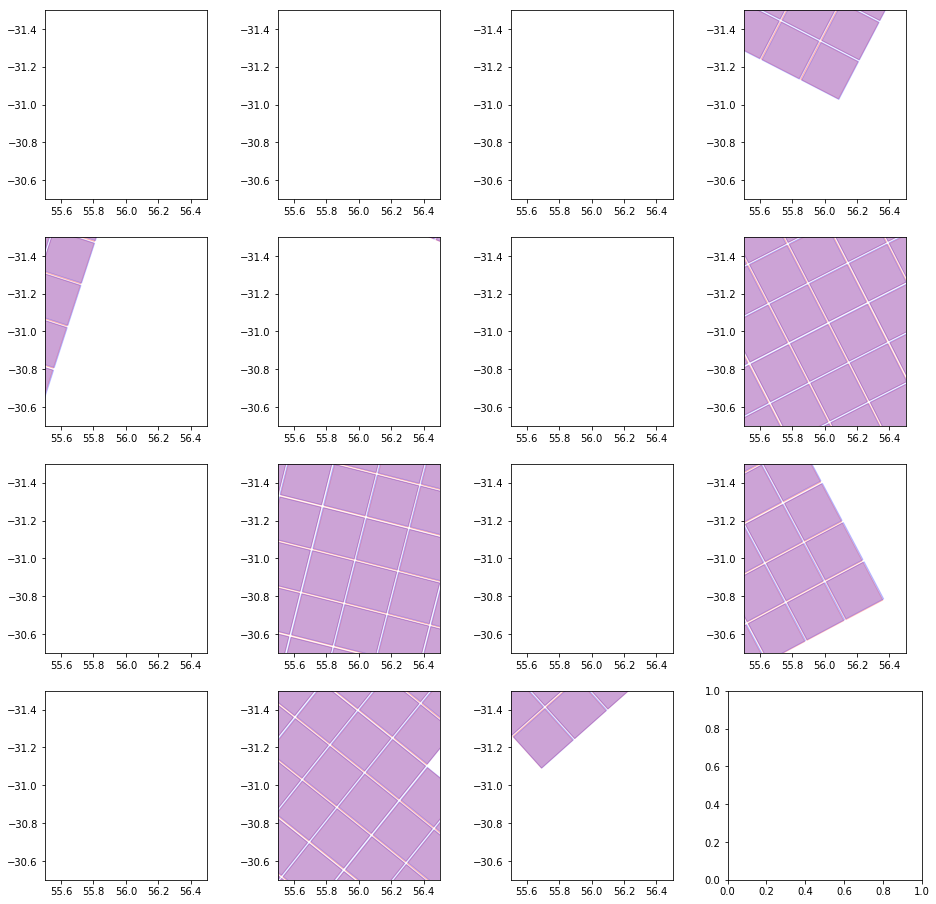

In [20]:
max_dec = -30.5
min_dec = -31.5
avg_dec = (min_dec + max_dec)/2
size = 16
dec_size = size
ra_size = dec_size * np.cos(np.deg2rad(avg_dec))
aspect_ratio = dec_size / ra_size

fig, axes = plt.subplots(4, 4, figsize=(size, size))

visit_paths = glob(deep_diff_path+'/*')
visit_paths.reverse()
for avisit, ax in zip(visit_paths[:16], axes.flatten()):
    dirname = os.path.basename(avisit)
    n_visit, filt = dirname.strip('v').split('-')
    n_visit = int(n_visit)

    dmu.plot_focal_plane(b, n_visit, ax, color='red')
    dmu.plot_focal_plane_fast(b, n_visit, ax, color='blue')
    ax.set_aspect(aspect_ratio)
    ax.set_xlim(55.5, 56.5)
    ax.set_ylim(-30.5, -31.5)
    #plt.grid()
plt.show()

In [60]:
pathminion = dmu.make_patch(minion_skycorners)
pathbutler = dmu.make_patch(sky_corners)

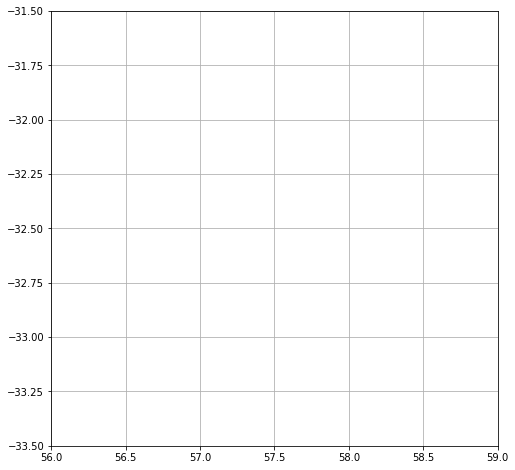

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
patch = patches.PathPatch(pathminion, alpha=1, lw=1)
ax.add_patch(patch)
patch = patches.PathPatch(pathbutler, alpha=1, lw=1)
ax.add_patch(patch)
ax.set_xlim(56, 59)
ax.set_ylim(-33.5, -31.5)
plt.grid()
plt.show()

In [62]:
minion_skycorners

[SpherePoint(58.7489001011374*geom.degrees, -32.567856231992224*geom.degrees),
 SpherePoint(58.643706022284974*geom.degrees, -32.77581747142925*geom.degrees),
 SpherePoint(58.88691331071213*geom.degrees, -32.86270063860951*geom.degrees),
 SpherePoint(58.99166637715746*geom.degrees, -32.65454535908331*geom.degrees)]

In [74]:
reload(dmu)

<module 'dm_utilities' from '../dm_utilities.py'>

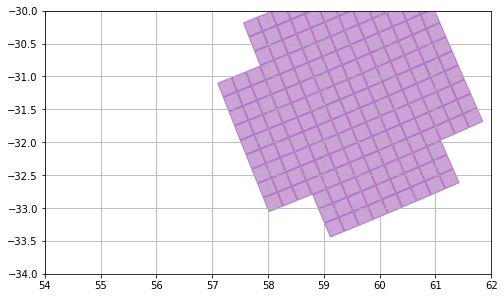

In [120]:
max_dec = -30.5
min_dec = -31.5
avg_dec = (min_dec + max_dec)/2
size = 8
dec_size = size
ra_size = dec_size * np.cos(np.deg2rad(avg_dec))
aspect_ratio = dec_size / ra_size

fig, ax = plt.subplots(1, 1, figsize=(size, size))
dmu.plot_focal_plane(b, n_visit, ax, color='red')
dmu.plot_focal_plane_fast(b, n_visit, ax, color='blue')
ax.set_aspect(aspect_ratio)
ax.set_xlim(55.5, 56.5)
ax.set_ylim(-30.5, -31.5)
plt.grid()
plt.show()

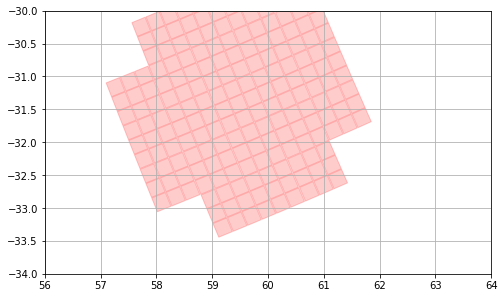

In [119]:
max_dec = -30.
min_dec = -34.
avg_dec = (min_dec + max_dec)/2
size = 8
dec_size = size
ra_size = dec_size * np.cos(np.deg2rad(avg_dec))
aspect_ratio = dec_size / ra_size

fig, ax = plt.subplots(1, 1, figsize=(size, size))
dmu.plot_focal_plane_fast(b, n_visit, ax)
ax.set_aspect(aspect_ratio)
ax.set_xlim(56, 64)
ax.set_ylim(-34, -30.0)
plt.grid()
plt.show()

In [118]:
reload(dmu)

<module 'dm_utilities' from '../dm_utilities.py'>